El objetivo de este problema consiste en implementar una red neuronal que permita clasificar\
la revisiones realizadas en IMDB como positivas o negativas. Para ello vamos a trabajar con\
los datos que provee la librería keras (datasets.imbd.load_data(num_words=10000)).\
Los datos se encuentran codificados según el diccionario imdb.get_word_index(), donde\
cada palabra esta codificada con un número. Antes de poder trabajar con los datos es nece-\
sario preprocesar los mismos de forma similar a cómo se hizo con la BD mnist. Analizar el\
rendimiento de la red propuesta, y en caso de overfitting estudie el impacto que tienen las\
distintas variantes de regularización vistas en clase para mejorar la generalización de la red\
(𝐿2, BN y Drop out).

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt
import gc


%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=10000)

word_index = keras.datasets.imdb.get_word_index()

In [3]:
top_values = [i for i in word_index if word_index[i]<10]
print(top_values)

['it', 'is', 'in', 'of', 'a', 'br', 'the', 'and', 'to']


In [4]:
def get_word(word_index, idx):
    l = [word for word in word_index if word_index[word] == idx]
    return l[0]

#Como las reviews ya vienen ordenadas por index, no puedo imprimir el texto,
#Solo una secuenca de palabras ordenadas por frecuencia de aparicion
def print_review(review, word_index):
    streview = []
    for idx in review:
        streview.append(get_word(word_index, idx))
    print(' '.join(streview))
    return None

print_review(x_train[9], word_index)

the as on there plot she's iii film that for find that saw better just is along wrong silly awesome or play this you doing was one in own that successful are make and old plot gets unfortunately of on was although except value omar that with her do they gets for that with timing really way that is played character i i what poor set but is along 100 studio on film is missing br received fact to is mercifully br fabulous and them powers is tapes br enjoys indicate good women show to one good played i i was plain film because avoid for of totally it time do period it couple in college in viewers get br of my to of material it yet br out more


In [5]:
X = [1, 3, 4, 1, 1, 1, 5, 6, 9, 9]
d = {x:X.count(x) for x in X}
data = np.zeros((1, 10))
data[0, list(d.keys())]+=list(d.values())
data

array([[0., 4., 0., 1., 1., 1., 1., 0., 0., 2.]])

In [6]:
def preprocess(X, num_words=10000):
    m = len(X)
    
    data = np.zeros((m, num_words), dtype=float)

    for i, review in enumerate(X):
        d = {idx:review.count(idx) for idx in review}
        data[i, list(d.keys())] += list(d.values())
    
    return data

In [7]:
Xtrain = preprocess(x_train)
Xtrain.shape

(25000, 10000)

In [8]:
Xtest = preprocess(x_test)
Xtest.shape

(25000, 10000)

In [9]:
def plot(hist):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax1.plot(hist.history['loss'], label='BCE')
    ax1.plot(hist.history['val_loss'], label='val_BCE')
    ax1.set_xlabel('Epocas', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)
    ax1.legend(loc='best')

    ax2.plot(hist.history['binary_accuracy'], label='BCE')
    ax2.plot(hist.history['val_binary_accuracy'], label='val_BCE')
    ax2.set_xlabel('Epocas', fontsize=15)
    ax2.set_ylabel('Accuracy', fontsize=15)
    ax2.legend(loc='best')

    fig.tight_layout()
    plt.show()
    return None

In [10]:
gc.collect()

22

Una vez preprocesados los datos, vamos a implementar una red neuronal de\
2 capas ocultas de 30 neuronas cada una, sin ninguna regularización

In [11]:
opt = keras.optimizers.Adam(learning_rate=.0001)

input = keras.layers.Input(shape=(10000,))
l1 = keras.layers.Dense(25, activation='relu', use_bias=True)(input)
l2 = keras.layers.Dense(25, activation='relu', use_bias=True)(l1)
l3 = keras.layers.Dense(10, activation='relu', use_bias=True)(l2)

output = keras.layers.Dense(1, activation='linear', use_bias=True)(l3)

model = keras.Model(inputs=input, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 25)                250025    
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dense_2 (Dense)             (None, 10)                260       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 250,946
Trainable params: 250,946
Non-trainable params: 0
_________________________________________________________________


In [12]:
keras.backend.clear_session()

model.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[keras.metrics.BinaryAccuracy(threshold=.9)])
hist = model.fit(Xtrain, y_train, validation_data=(Xtest, y_test), epochs=100, 
                  batch_size=50, verbose=0)

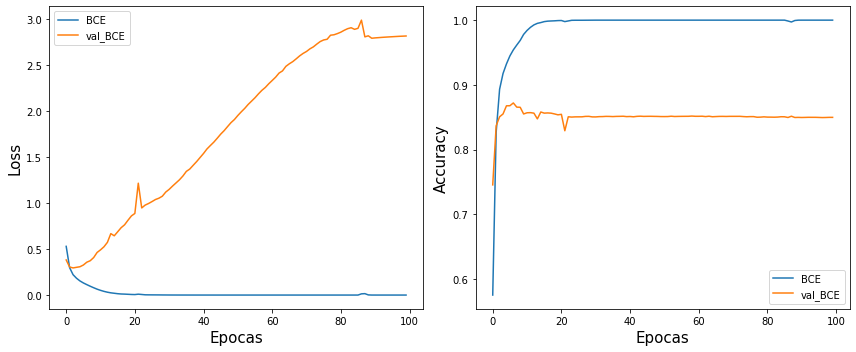

In [13]:
plot(hist)

Mismo modelo con regularización L2

In [14]:
keras.backend.clear_session()

opt = keras.optimizers.Adam(learning_rate=.0001)
reg = keras.regularizers.L2(0.1)

input = keras.layers.Input(shape=(10000,))
l1 = keras.layers.Dense(25, activation='relu', use_bias=True, kernel_regularizer=reg)(input)
l2 = keras.layers.Dense(25, activation='relu', use_bias=True, kernel_regularizer=reg)(l1)
l3 = keras.layers.Dense(10, activation='relu', use_bias=True, kernel_regularizer=reg)(l2)
output = keras.layers.Dense(1, activation='linear', use_bias=True)(l3)

model = keras.Model(inputs=input, outputs=output)

model.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[keras.metrics.BinaryAccuracy(threshold=.9)])
histL2 = model.fit(Xtrain, y_train, validation_data=(Xtest, y_test), epochs=100, 
                  batch_size=50, verbose=0)

keras.backend.clear_session()

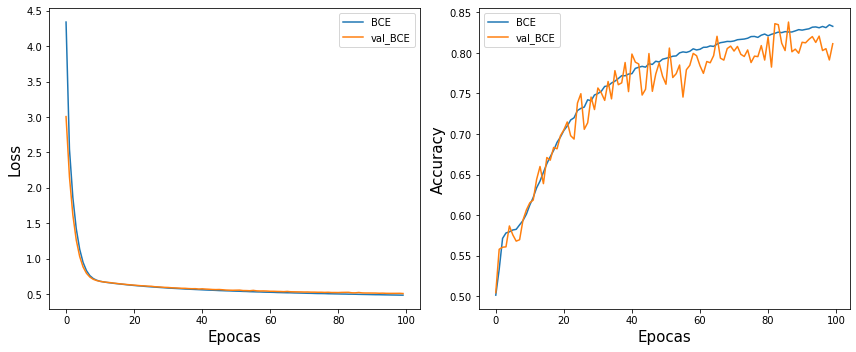

In [15]:
plot(histL2)

Ahora con Dropout

In [16]:
keras.backend.clear_session()

opt = keras.optimizers.Adam(learning_rate=.0001)

input = keras.layers.Input(shape=(10000,))

l1 = keras.layers.Dense(25, activation='relu', use_bias=True)(input)
drop1 = keras.layers.Dropout(.5)(l1)

l2 = keras.layers.Dense(25, activation='relu', use_bias=True)(drop1)
drop2 = keras.layers.Dropout(.5)(l2)

l3 = keras.layers.Dense(10, activation='relu', use_bias=True)(drop2)
drop3 = keras.layers.Dropout(.5)(l3)

output = keras.layers.Dense(1, activation='linear', use_bias=True)(drop3)

model = keras.Model(inputs=input, outputs=output)

model.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[keras.metrics.BinaryAccuracy(threshold=.9)])
histDrop = model.fit(Xtrain, y_train, validation_data=(Xtest, y_test), epochs=100, 
                  batch_size=50, verbose=0)

keras.backend.clear_session()

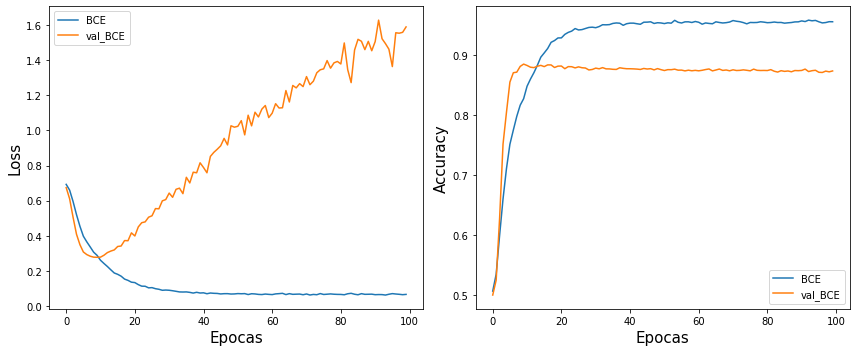

In [17]:
plot(histDrop)

Por último aplicamos Batch Normalization

In [18]:
keras.backend.clear_session()

opt = keras.optimizers.Adam(learning_rate=.0001)

input = keras.layers.Input(shape=(10000,))

l1 = keras.layers.Dense(25, activation='relu', use_bias=True)(input)
BN1 = keras.layers.BatchNormalization()(l1)

l2 = keras.layers.Dense(25, activation='relu', use_bias=True)(BN1)
BN2 = keras.layers.BatchNormalization()(l2)

l3 = keras.layers.Dense(10, activation='relu', use_bias=True)(BN2)
BN3 = keras.layers.BatchNormalization()(l3)

output = keras.layers.Dense(1, activation='linear', use_bias=True)(BN3)

model = keras.Model(inputs=input, outputs=output)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 25)                250025    
                                                                 
 batch_normalization (BatchN  (None, 25)               100       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 batch_normalization_1 (Batc  (None, 25)               100       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 10)                260   

In [19]:
gc.collect()

20108

In [20]:
model.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[keras.metrics.BinaryAccuracy(threshold=.9)])
histBN = model.fit(Xtrain, y_train, validation_data=(Xtest, y_test), epochs=100, 
                  batch_size=50, verbose=0)

keras.backend.clear_session()

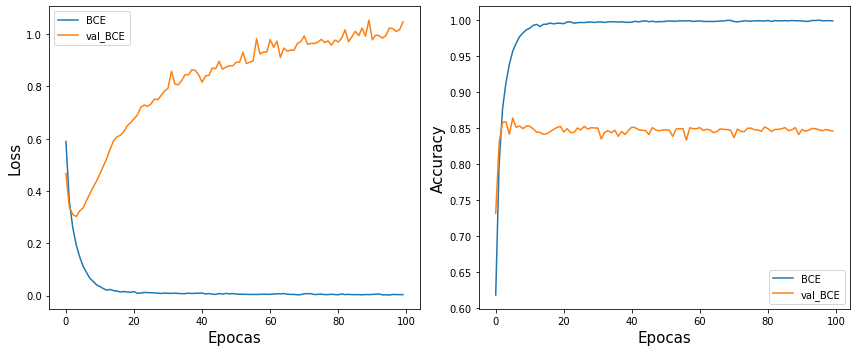

In [21]:
plot(histBN)

Finalmente, probemos Dropout con L2 reg

In [25]:
keras.backend.clear_session()
gc.collect()

13668

In [26]:
keras.backend.clear_session()

opt = keras.optimizers.Adam(learning_rate=.0001)
reg = keras.regularizers.L2(0.01)

input = keras.layers.Input(shape=(10000,))

l1 = keras.layers.Dense(25, activation='relu', use_bias=True, 
                        kernel_regularizer=reg)(input)
drop1 = keras.layers.Dropout(.5)(l1)

l2 = keras.layers.Dense(25, activation='relu', use_bias=True,
                        kernel_regularizer=reg)(drop1)
drop2 = keras.layers.Dropout(.5)(l2)

l3 = keras.layers.Dense(10, activation='relu', use_bias=True,
                        kernel_regularizer=reg)(drop2)
drop3 = keras.layers.Dropout(.5)(l3)

output = keras.layers.Dense(1, activation='linear', use_bias=True,
                            kernel_regularizer=reg)(drop3)

model = keras.Model(inputs=input, outputs=output)

model.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[keras.metrics.BinaryAccuracy(threshold=.9)])
histDropL2 = model.fit(Xtrain, y_train, validation_data=(Xtest, y_test), epochs=100, 
                  batch_size=50, verbose=2)

keras.backend.clear_session()

Epoch 1/100
500/500 - 8s - loss: 1.2473 - binary_accuracy: 0.5047 - val_loss: 1.0749 - val_binary_accuracy: 0.5006 - 8s/epoch - 16ms/step
Epoch 2/100
500/500 - 6s - loss: 0.9843 - binary_accuracy: 0.5460 - val_loss: 0.8789 - val_binary_accuracy: 0.5434 - 6s/epoch - 13ms/step
Epoch 3/100
500/500 - 7s - loss: 0.8384 - binary_accuracy: 0.6118 - val_loss: 0.7507 - val_binary_accuracy: 0.6317 - 7s/epoch - 13ms/step
Epoch 4/100
500/500 - 6s - loss: 0.7370 - binary_accuracy: 0.6667 - val_loss: 0.6554 - val_binary_accuracy: 0.7326 - 6s/epoch - 11ms/step
Epoch 5/100
500/500 - 5s - loss: 0.6662 - binary_accuracy: 0.7069 - val_loss: 0.5815 - val_binary_accuracy: 0.8083 - 5s/epoch - 11ms/step
Epoch 6/100
500/500 - 5s - loss: 0.6121 - binary_accuracy: 0.7398 - val_loss: 0.5534 - val_binary_accuracy: 0.7816 - 5s/epoch - 11ms/step
Epoch 7/100
500/500 - 6s - loss: 0.5783 - binary_accuracy: 0.7567 - val_loss: 0.5124 - val_binary_accuracy: 0.8413 - 6s/epoch - 11ms/step
Epoch 8/100
500/500 - 6s - loss: 0

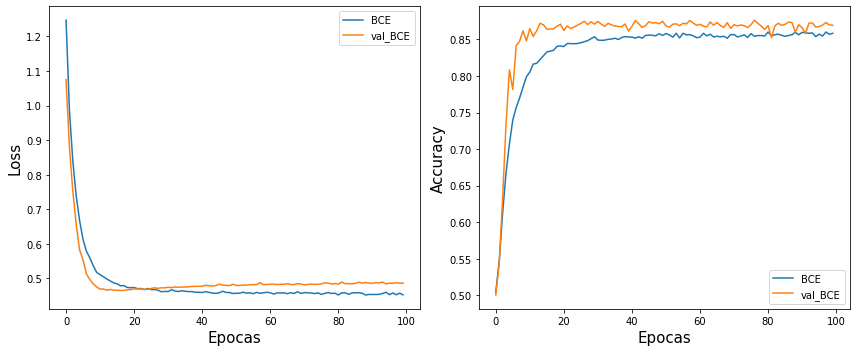

In [27]:
plot(histDropL2)